In [1]:
# 
!pip install watermark
!pip install transformers datasets torch scikit-learn pandas numpy

In [2]:
# Import of libraries

# System libraries
import random
import re
import unicodedata
import itertools

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt

# Model transformers
import torch
import pandas as pd
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from keras.preprocessing.sequence import pad_sequences

# Importar display para mostrar imagens no Jupyterfrom keras.preprocessing.sequence import pad_sequences
from IPython.display import display  

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

Python version in this Jupyter Notebook: 3.10.14
Author: Library versions

platform    : 1.0.8
keras       : 3.3.3
plotly      : 5.22.0
torch       : 2.4.0
IPython     : 8.21.0
seaborn     : 0.12.2
numpy       : 1.26.4
pandas      : 2.2.3
re          : 2.2.1
transformers: 4.46.3
matplotlib  : 3.7.5
watermark   : 2.5.0



In [3]:
# Carregar o dataset
train_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

In [4]:
# Visualizar os dados
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [5]:
train_df.tail()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0
57476,4294947231,gemini-pro-dev-api,gpt-4-1106-preview,"[""three kids eat three apples in three days, h...","[""27 apples""]","[""If three kids eat three apples in three days...",1,0,0


In [6]:
train_df.shape

(57477, 9)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [8]:
train_df.dtypes

id                 int64
model_a           object
model_b           object
prompt            object
response_a        object
response_b        object
winner_model_a     int64
winner_model_b     int64
winner_tie         int64
dtype: object

# Pré-processamento

In [9]:
# Concatenar os textos
train_df['combined_text'] = train_df['prompt'] + " [SEP] " + train_df['response_a'] + " [SEP] " + train_df['response_b']

# Preparar o dataset de teste
test_df['combined_text'] = test_df['prompt'] + "[SEP]" + test_df['response_a'] + "[SEP]" + test_df['response_b']

# Concatenar as colunas
train_df['label'] = train_df[['winner_model_a', 
                              'winner_model_b', 
                              'winner_tie']].idxmax(axis=1)

# Visualizando
train_df.head(n=10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,combined_text,label
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[""Is it morally right to try to have a certain...",winner_model_a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,"[""What is the difference between marriage lice...",winner_model_b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,"[""explain function calling. how would you call...",winner_tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,"[""How can I create a test set for a very rare ...",winner_model_a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,"[""What is the best way to travel from Tel-Aviv...",winner_model_b
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,"[""Construct a rap battle, in the style of Epic...",winner_model_b
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,"[""Why water is not used in bath tub?""] [SEP] [...",winner_model_a
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,"[""\""Bacteria is life on Mars but a heartbeat i...",winner_model_b
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,"[""translate to russian the followig sentence ...",winner_model_b
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,"[""From now, you *always* have to talk as if yo...",winner_model_b


# Feature Engineering

In [10]:
# Mapear labels para inteiros
label_mapping = {'winner_model_a': 0, 
                 'winner_model_b': 1, 
                 'winner_tie': 2}

# Váraivel alvo
train_df['label'] = train_df['label'].map(label_mapping)

In [11]:
# Visualizando
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,combined_text,label
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[""Is it morally right to try to have a certain...",0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,"[""What is the difference between marriage lice...",1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,"[""explain function calling. how would you call...",2
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,"[""How can I create a test set for a very rare ...",0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,"[""What is the best way to travel from Tel-Aviv...",1


# Limpeza dados

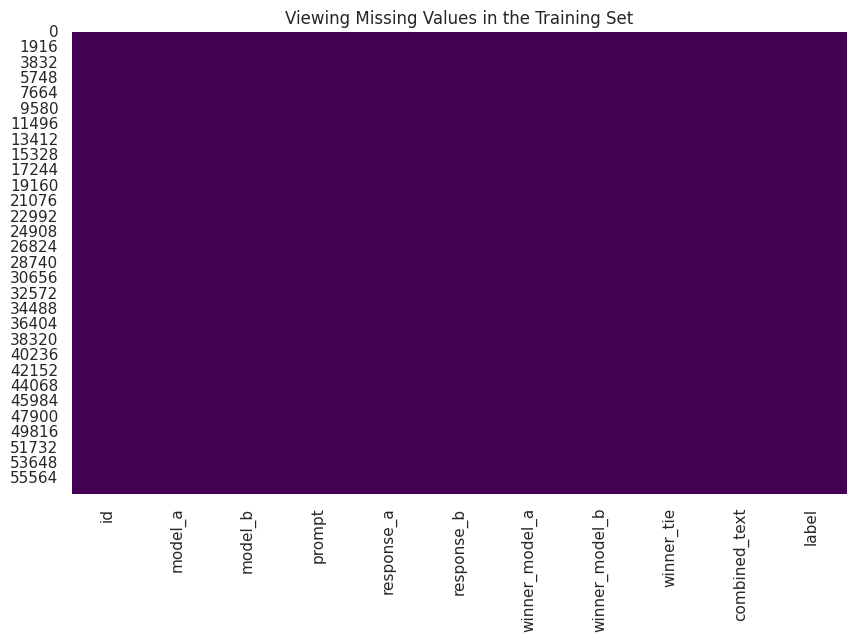

In [12]:
# View missing values

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Viewing Missing Values in the Training Set")
plt.show()

In [13]:
print("Number of missing values ​​per column:")
print(train_df.isnull().sum())

Number of missing values ​​per column:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
combined_text     0
label             0
dtype: int64


# Análise exploratoria de dados

In [74]:
train_df.winner_model_a.value_counts()

winner_model_a
0    37413
1    20064
Name: count, dtype: int64

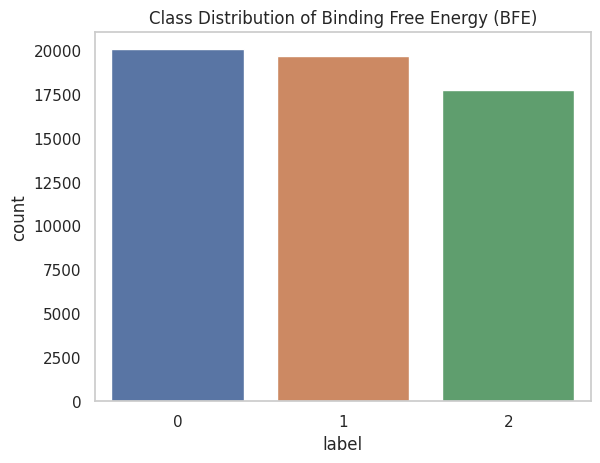


Class Distribution:
label
0    20064
1    19652
2    17761
Name: count, dtype: int64


In [14]:
# 3. Distribution of the Target Variable "Class"
sns.countplot(x='label', data=train_df)
plt.title("Class Distribution of Binding Free Energy (BFE)")
plt.grid(False)
plt.show()

print("\nClass Distribution:")
print(train_df['label'].value_counts())

In [15]:
# 1. Basic Characteristics of the Dataset
print("Dataset Information:")
train_df.info()
print()
print("\nSummary Statistics:")
train_df.describe().T

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
 9   combined_text   57477 non-null  object
 10  label           57477 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.8+ MB


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
id,57477.0,2.142564e+09,1.238327e+09,30192.0,1.071821e+09,2.133658e+09,3.211645e+09,4.294947e+09
winner_model_a,57477.0,3.490788e-01,4.766831e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
winner_model_b,57477.0,3.419107e-01,4.743540e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
winner_tie,57477.0,3.090106e-01,4.620895e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
label,57477.0,9.599318e-01,8.102440e-01,0.0,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00


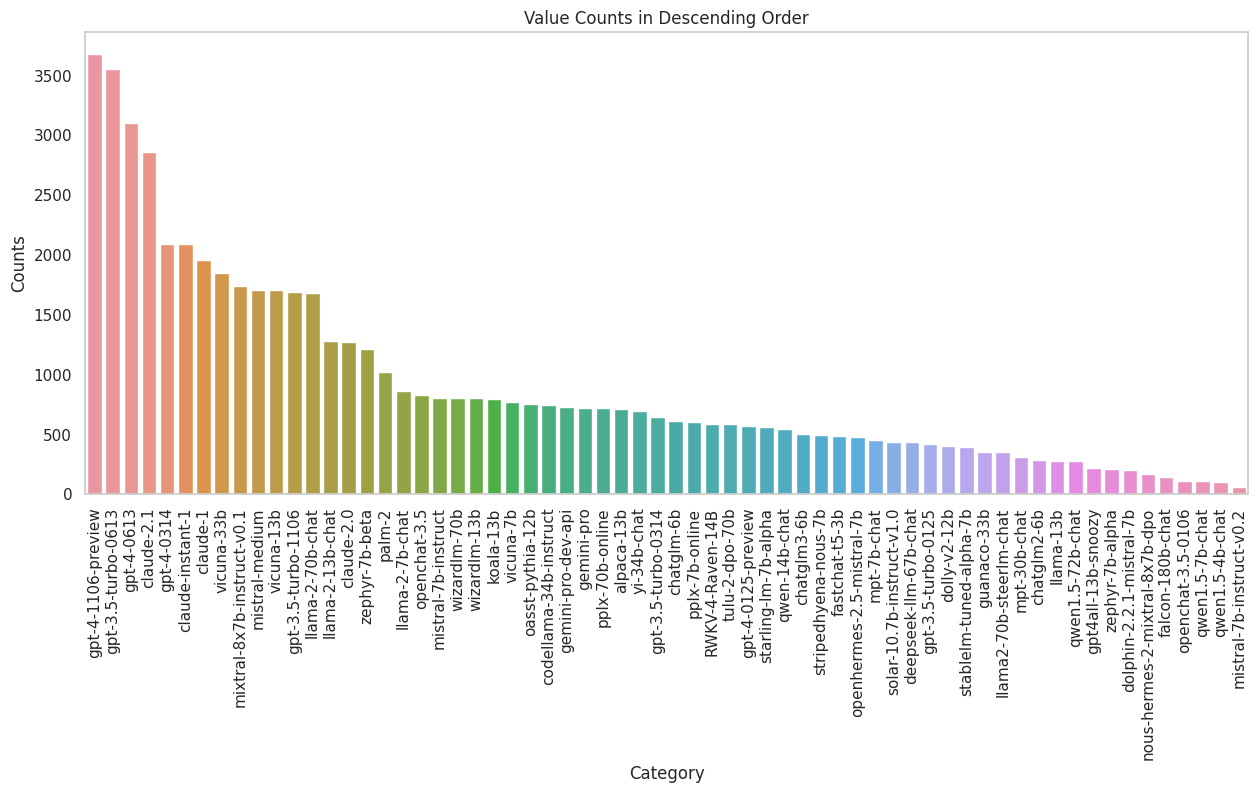

In [16]:
# Get value counts in descending order
value_counts2 = train_df['model_a'].value_counts(ascending=False)

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x=value_counts2.index, y=value_counts2.values)
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Value Counts in Descending Order')
plt.grid(False)
plt.show()

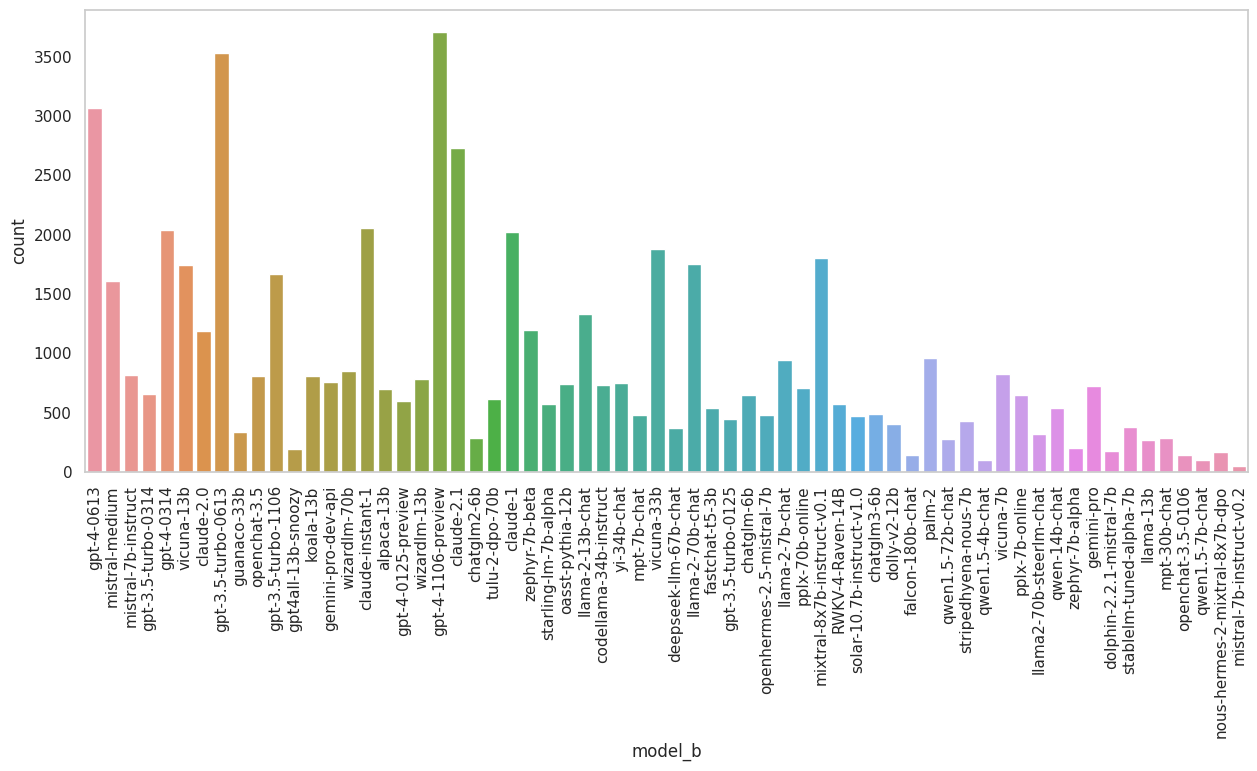

model_b
gpt-4-1106-preview          3709
gpt-3.5-turbo-0613          3530
gpt-4-0613                  3066
claude-2.1                  2724
claude-instant-1            2051
                            ... 
falcon-180b-chat             141
openchat-3.5-0106            136
qwen1.5-7b-chat              102
qwen1.5-4b-chat              100
mistral-7b-instruct-v0.2      46
Name: count, Length: 64, dtype: int64


In [17]:
plt.figure(figsize=(15, 6))
sns.countplot(x='model_b', data=train_df)
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

print(train_df['model_b'].value_counts())

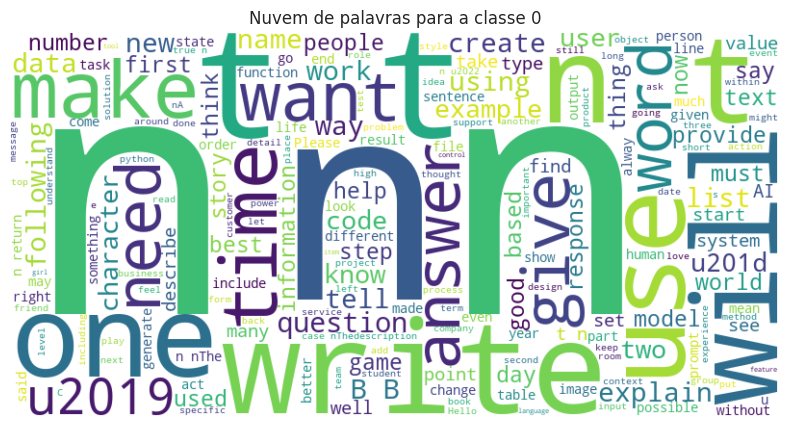

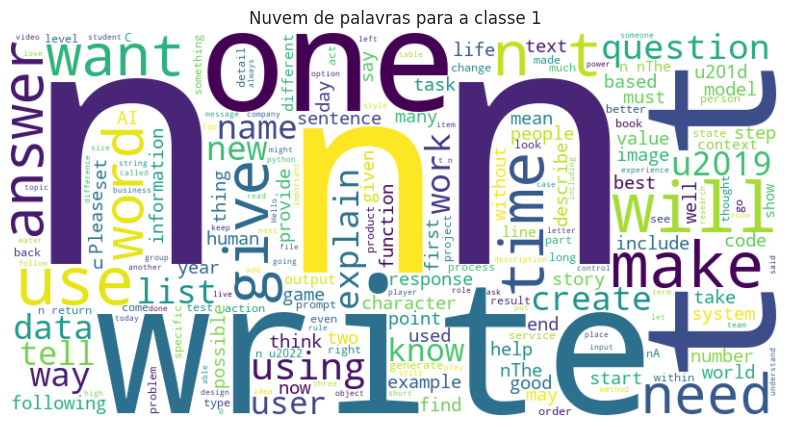

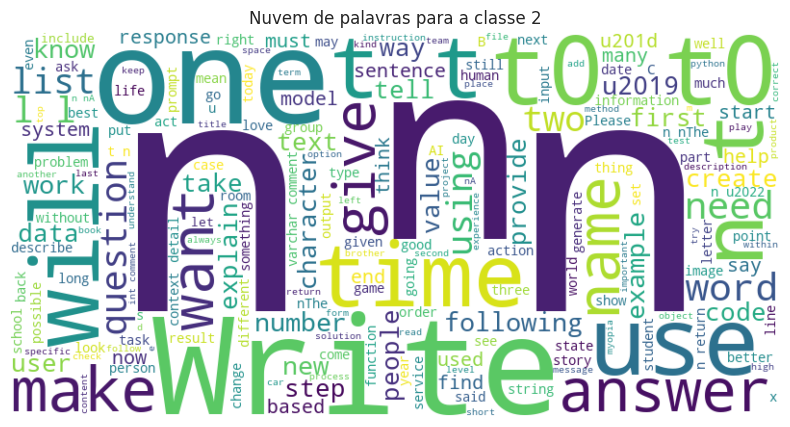

In [18]:
from wordcloud import WordCloud

# Crie uma lista de classes únicas na coluna 'label'
labels = train_df['label'].unique()

# Loop para cada classe e gerar a nuvem de palavras
for label in labels:
    textos_prompt = ' '.join(train_df[train_df['label'] == label]['prompt'])

    # Gerar a nuvem de palavras para cada classe
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white').generate(textos_prompt)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de palavras para a classe {label}')
    plt.show()

# Vetorização

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  

# Inicializar TfidfVectorizers para cada coluna de texto
vectorizer_prompt = TfidfVectorizer(max_features=500)   
vectorizer_resp_a = TfidfVectorizer(max_features=500)
vectorizer_resp_b = TfidfVectorizer(max_features=500)

# Ajustar e transformar cada coluna de texto para o conjunto de treino
train_prompt_features = vectorizer_prompt.fit_transform(train_df['prompt'])
train_resp_a_features = vectorizer_resp_a.fit_transform(train_df['response_a'])
train_resp_b_features = vectorizer_resp_b.fit_transform(train_df['response_b'])

# Combinar as matrizes TF-IDF para o conjunto de treino
train_combined_features = hstack([train_prompt_features, train_resp_a_features, train_resp_b_features])

# Ajustar e transformar cada coluna de texto para o conjunto de teste
test_prompt_features = vectorizer_prompt.transform(test_df['prompt'])
test_resp_a_features = vectorizer_resp_a.transform(test_df['response_a'])
test_resp_b_features = vectorizer_resp_b.transform(test_df['response_b'])

# Combinar as matrizes TF-IDF para o conjunto de teste
test_combined_features = hstack([test_prompt_features, test_resp_a_features, test_resp_b_features])

# Armazenar o resultado para o conjunto de teste
final_test_features = test_combined_features

# A matriz de features para o conjunto de treino
final_train_features = train_combined_features

# Target column division

In [32]:
X = test_combined_features
y = train_df[['winner_model_a','winner_model_b','winner_tie']]

# Model Training

In [50]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjunto de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, train_df['label'], 
                                                  test_size=0.2, random_state=42, 
                                                  stratify=train_df['label'])

# Viewing training data
print("Viewing rows and columns given by X train", X_train.shape)

# Viewing test data
print("Viewing rows and columns given y train", y_train.shape)

Viewing rows and columns given by X train (45981, 1500)
Viewing rows and columns given y train (45981,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificar os rótulos para valores inteiros
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [52]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Parâmetros avançados com suporte a GPU
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': -1,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': y_train.nunique(),  # Número de classes
    'device': 'gpu',
    'random_state': 42
}

# Criar o modelo LightGBM com suporte a GPU
model = LGBMClassifier(**lgbm_params)

# Treinar o modelo
model.fit(X_train, y_train)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 351840
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1499
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 38 dense feature groups (1.75 MB) transferred to GPU in 0.002557 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


LGBMClassifier(colsample_bytree=0.8, device='gpu', learning_rate=0.05,
               n_estimators=500, num_class=3, objective='multiclass',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

In [67]:
# Fazer previsões no conjunto de validação
y_pred = model.predict(X_val)

# Fazer previsões no conjunto de teste
y_test_pred = model.predict(test)

# Fazer previsões AUC-ROC
y_pred = model.predict(X_val)

# Usar X_val, não test
y_proba = model.predict_proba(X_val)  

In [82]:
# Fazer previsões no conjunto de validação
y_pred_val = model.predict(X_val)
y_proba_val = model.predict_proba(X_val)

# Salvar as previsões e probabilidades em dataframes para a validação
val_predictions_df = pd.DataFrame({
    'prediction_val': y_pred_val,
    'proba_0_val': y_proba_val[:, 0],  # Probabilidade para a classe 0
    'proba_1_val': y_proba_val[:, 1],  # Probabilidade para a classe 1
})

# Fazer previsões no conjunto de teste
y_test_pred = model.predict(test)
y_proba_test = model.predict_proba(test)

# Salvar as previsões e probabilidades em dataframes para o teste
test_predictions_df = pd.DataFrame({
    'prediction_test': y_test_pred,
    'proba_0_test': y_proba_test[:, 0],  # Probabilidade para a classe 0
    'proba_1_test': y_proba_test[:, 1],  # Probabilidade para a classe 1
})

# Concatenar o dataframe de previsões com o dataframe original de treino
combined_df = pd.concat([train_df, val_predictions_df, test_predictions_df], axis=1)

combined_df.head(n=10)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,combined_text,label,prediction_val,proba_0_val,proba_1_val,prediction_test,proba_0_test,proba_1_test
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,"[""Is it morally right to try to have a certain...",0,0.0,0.460989,0.200797,2.0,0.182371,0.318544
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,"[""What is the difference between marriage lice...",1,0.0,0.360964,0.306251,2.0,0.370666,0.251700
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,"[""explain function calling. how would you call...",2,0.0,0.419747,0.290580,1.0,0.247526,0.429946
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,"[""How can I create a test set for a very rare ...",0,1.0,0.221969,0.522867,NaN,NaN,NaN
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,"[""What is the best way to travel from Tel-Aviv...",1,2.0,0.275356,0.238378,NaN,NaN,NaN
5,292873,vicuna-13b,gpt-4-0314,"[""Construct a rap battle, in the style of Epic...","[""[Zeus]\nYo, it's the king of the gods on the...","[""(Verse 1 - Zeus)\n\nI'm the king of the gods...",0,1,0,"[""Construct a rap battle, in the style of Epic...",1,0.0,0.526178,0.351876,NaN,NaN,NaN
6,313413,mixtral-8x7b-instruct-v0.1,vicuna-13b,"[""Why water is not used in bath tub?""]","[""Water is actually used in a bath tub. A bath...","[""Water is not used in a bath tub because it i...",1,0,0,"[""Why water is not used in bath tub?""] [SEP] [...",0,0.0,0.627771,0.176032,NaN,NaN,NaN
7,370945,gemini-pro,claude-2.0,"[""\""Bacteria is life on Mars but a heartbeat i...","[""Dune""]","[""This quote seems to be referencing the debat...",0,1,0,"[""\""Bacteria is life on Mars but a heartbeat i...",1,2.0,0.256743,0.251731,NaN,NaN,NaN
8,441448,gpt-3.5-turbo-0613,vicuna-13b,"[""translate to russian the followig sentence ...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...","[""\u0411\u043e\u043b\u044c\u0448\u0438\u0435 \...",0,1,0,"[""translate to russian the followig sentence ...",1,2.0,0.269985,0.355841,NaN,NaN,NaN
9,481524,gpt-4-0314,gpt-3.5-turbo-0613,"[""From now, you *always* have to talk as if yo...","[""Hewwo! OwO I'm an AI assistant, here to hewp...","[""Hewwo! I'm your new helpful assistant, owo! ...",0,1,0,"[""From now, you *always* have to talk as if yo...",1,0.0,0.470649,0.375253,NaN,NaN,NaN


In [85]:
data_llm = combined_df[["model_a", "prediction_val", "proba_0_val"]]
data_llm.head(n=10)

,model_a,prediction_val,proba_0_val
0,gpt-4-1106-preview,0.0,0.460989
1,koala-13b,0.0,0.360964
2,gpt-3.5-turbo-0613,0.0,0.419747
3,llama-2-13b-chat,1.0,0.221969
4,koala-13b,2.0,0.275356
5,vicuna-13b,0.0,0.526178
6,mixtral-8x7b-instruct-v0.1,0.0,0.627771
7,gemini-pro,2.0,0.256743
8,gpt-3.5-turbo-0613,2.0,0.269985
9,gpt-4-0314,0.0,0.470649


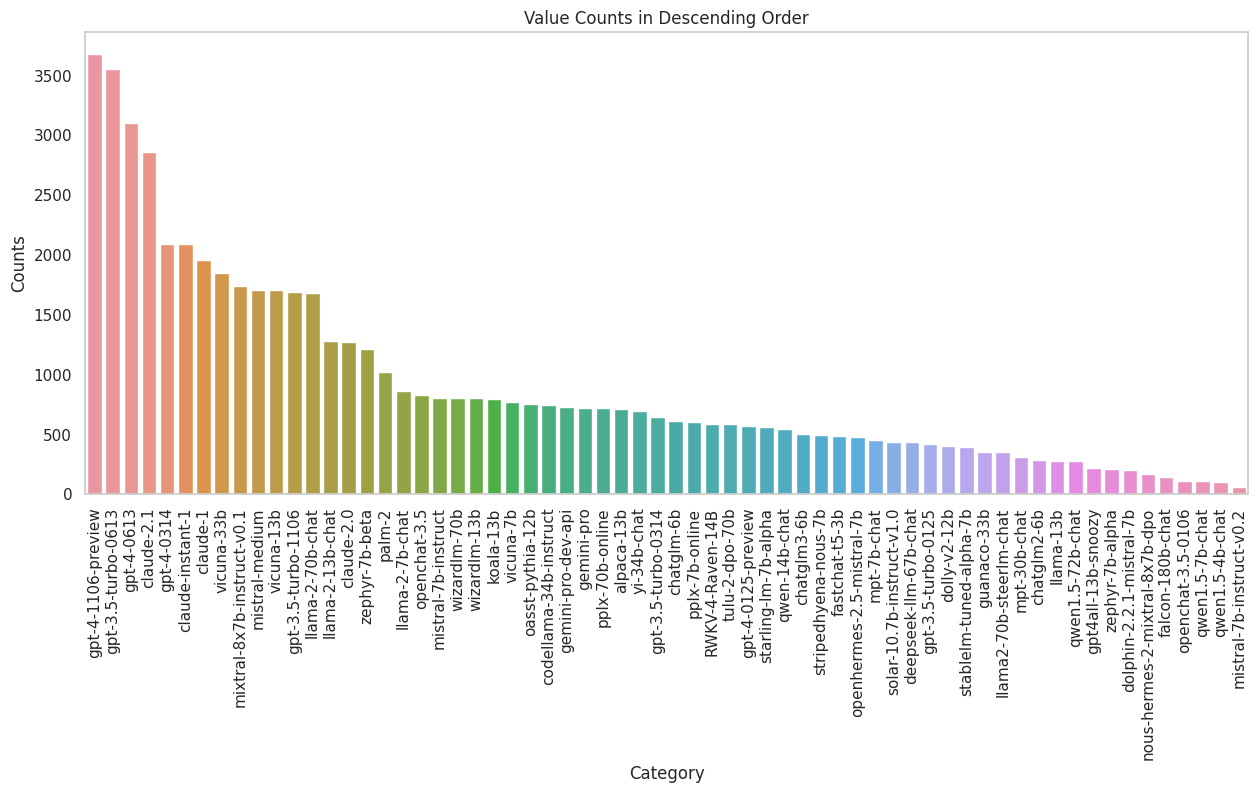

In [87]:
# Get value counts in descending order
value_counts3 = data_llm['model_a'].value_counts(ascending=False)

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x=value_counts3.index, y=value_counts3.values)
plt.xlabel('Category')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Value Counts in Descending Order')
plt.grid(False)
plt.show()

<Axes: xlabel='proba_0_val', ylabel='Count'>

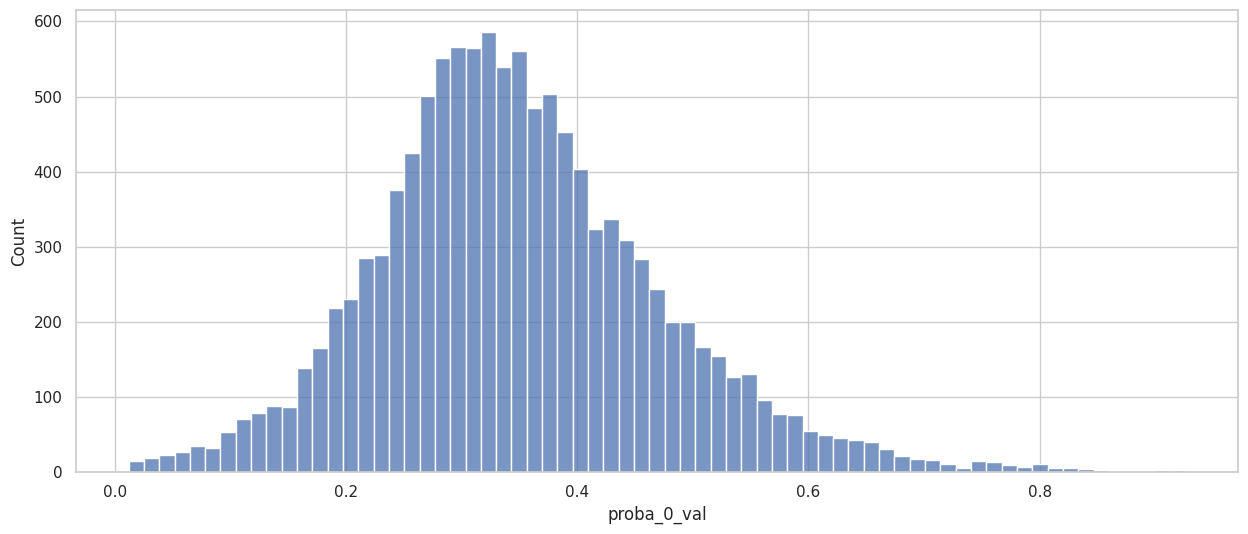

In [90]:
plt.figure(figsize=(15, 6))

sns.histplot(data_llm["proba_0_val"])

In [66]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# AUC-ROC
if len(np.unique(y_val)) > 2:  # Multiclasse
    # Binarizar os rótulos para calcular AUC-ROC
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)  # Rótulos binarizados
    auc_roc = roc_auc_score(y_val_binarized, y_proba, multi_class='ovr')
    print(f"AUC-ROC (Multiclasse - OVR): {auc_roc:.4f}")
else:  # Binário
    auc_roc = roc_auc_score(y_val, y_proba[:, 1])
    print(f"AUC-ROC (Binário): {auc_roc:.4f}")

AUC-ROC (Multiclasse - OVR): 0.6324


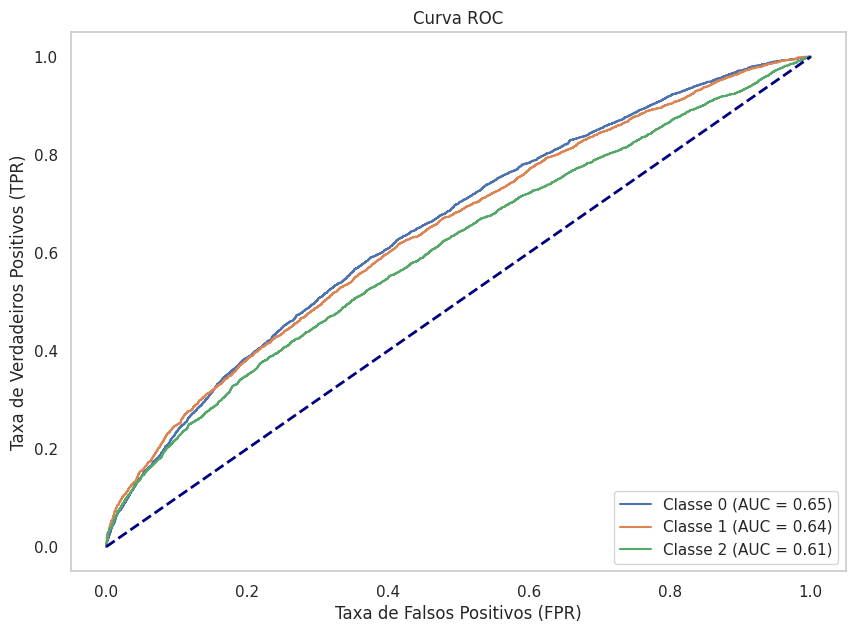

In [70]:
from sklearn.metrics import roc_curve, auc

# Fazer previsões de probabilidade
y_proba = model.predict_proba(X_val)

if len(np.unique(y_val)) > 2:  # Multiclasse
    # Para multiclasse, calcular a curva ROC para cada classe
    lb = LabelBinarizer()
    y_val_binarized = lb.fit_transform(y_val)  # Binarizar rótulos
    plt.figure(figsize=(10, 7))
    
    for i, class_name in enumerate(lb.classes_):
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Classe {class_name} (AUC = {roc_auc:.2f})')
    
    plt.title('Curva ROC Multiclasse')
else:  # Binário
    # Para classificação binária
    fpr, tpr, _ = roc_curve(y_val, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')

# Configuração do gráfico
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha diagonal
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

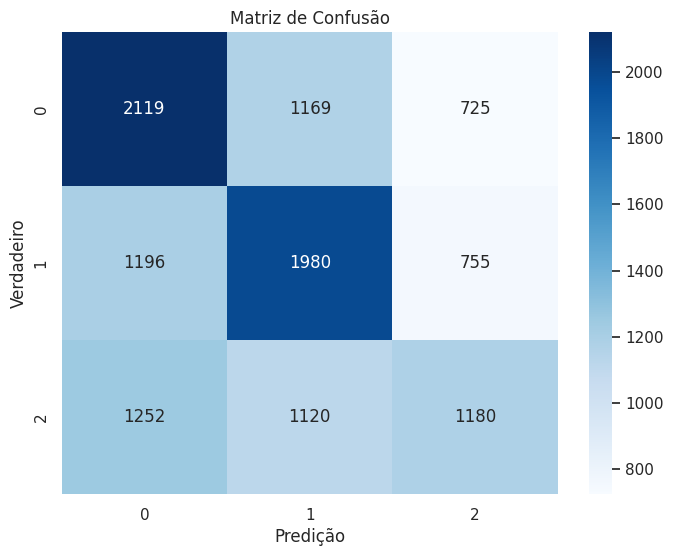

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtém os rótulos únicos de y_val
unique_labels = np.unique(y_val)

# Filtra rótulos válidos que estão presentes em y_val
class_labels = [label for label in ['winner_model_a', 'winner_model_b', 'winner_tie'] if label in unique_labels]

# Se não houver rótulos válidos, usa todos os rótulos únicos de y_val
if not class_labels:
    class_labels = unique_labels.tolist()

# Fazer previsões
y_pred = model.predict(X_val)

# Calcular a matriz de confusão
cm = confusion_matrix(y_val, y_pred, labels=class_labels)

# Exibir a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [69]:
# Avaliar o modelo
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.45920320111343077


In [68]:
# Avaliar o modelo
report = classification_report(y_val, y_pred)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49      4013
           1       0.46      0.50      0.48      3931
           2       0.44      0.33      0.38      3552

    accuracy                           0.46     11496
   macro avg       0.46      0.45      0.45     11496
weighted avg       0.46      0.46      0.45     11496



In [46]:
# Salvar as previsões para o conjunto de teste
output = pd.DataFrame({'id': test_df.index, 
                       'prediction': y_test_pred})

# Salvando modelo
output.to_csv('predictions_LGBMClassifier.csv', index=False)